# Sampling
Sampling the loss manifold using GLA 2nd


In [9]:
import sys
sys.path.append('/Users/zofia/packages/DataDrivenSampler-0.3/lib/python3.6/site-packages')

In [10]:
from DataDrivenSampler.models.model import model
import numpy as np
FLAGS = model.setup_parameters(
    batch_data_files=["dataset-twoclusters.csv"],
    batch_size=500,
    max_steps=1000,
    output_activation="linear",
    sampler="GeometricLangevinAlgorithm_2ndOrder",
    seed=426,
    step_width=1e-2
)
nn = model(FLAGS)
nn.init_network(None, setup="sample")
run_info, trajectory = nn.sample(return_run_info=True, \
  return_trajectories=True)
nn.finish()
print("Sample results")
print(np.asarray(run_info[0:10]))
print(np.asarray(trajectory[0:10]))

Parsing ['dataset-twoclusters.csv']
(TensorShape([Dimension(None), Dimension(2)]), TensorShape([Dimension(None), Dimension(1)]))
(tf.float32, tf.int32)
Picking as input columns: ['x1', 'x2']
x is (?, 2)
Creating nn layer output with 2, 1
Setting up output files for sample
Weight: <tf.Variable 'output/weights/Variable:0' shape=(2, 1) dtype=float64_ref>
Placeholder: Tensor("Placeholder:0", shape=(2, 1), dtype=float64)
Weight: <tf.Variable 'output/biases/Variable:0' shape=(1,) dtype=float64_ref>
Placeholder: Tensor("Placeholder_1:0", shape=(1,), dtype=float64)
Starting to sample
SAMPLED.
Sample results
[[1.0 0.0 '0.000' '4.16186523e+00' '5.25650000e-02' '4.16362175e+00'
  '1.75651877e-03' '1.18541766e-01' '1.18541766e-01' '2.12819406e+00'
  '0.00000000e+00' '1.75651877e-03' '2.12819406e+00']
 [2.0 1.0 '0.000' '4.14782476e+00' '9.36600000e-03' '4.16361549e+00'
  '1.57907237e-02' '2.36881630e-01' '1.18339864e-01' '2.11757114e+00'
  '0.00000000e+00' '8.77362125e-03' '2.12288260e+00']
 [3.0 2

In [11]:
import pandas as pd 
df = pd.DataFrame(trajectory)
df.to_csv("run_gla2.csv")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_run = pd.read_csv("run_gla2.csv", sep=',', header=0)
run=np.asarray(df_run.loc[:,['step','loss','kinetic_energy', 'total_energy']])
plt.scatter(run[:,0], run[:,1])
#plt.savefig('loss-step.png', bbox_inches='tight')
plt.show()


# Averages

Trajectory has shape (1000, 3)


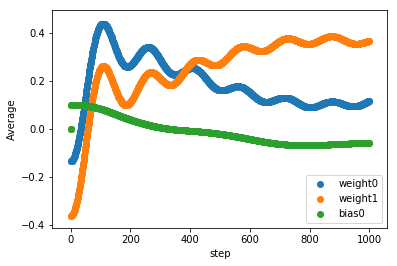

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from DataDrivenSampler.models.model import model

FLAGS = model.setup_parameters(
            trajectory_file="run_gla2.csv"
)
df_trajectory = pd.read_csv(FLAGS.trajectory_file, sep=',',header=0)
# check in which columns the weights are stores
#display(df_trajectory)
# save weigths only
traj=np.asarray(df_trajectory.values[:,3:])
print('Trajectory has shape '+repr(traj.shape))
conv=np.zeros(traj.shape)

# then we plot the running averages of the parameters
# inside weights
for i in range(1,traj.shape[0]):
    for d in range(traj.shape[1]):
        conv[i,d]=np.mean(traj[:i,d])
[plt.scatter(range(len(traj)), conv[:,i]) for i in range(traj.shape[1])]
plt.xlabel('step')
plt.ylabel('Average')

plt.legend(df_trajectory.axes[1][-3:])
#plt.savefig('step-parameters.png', bbox_inches='tight')
plt.show()


# Optimizing first and subsequent sampling
This is actually the recommended way of doing sampling: First make sure that the parameters start in a local minima and from there we explore the surrounding manifold.

In [24]:
from DataDrivenSampler.models.model import model
import numpy as np
FLAGS = model.setup_parameters(
batch_data_files=["dataset-twoclusters.csv"],
            batch_size=500,
            max_steps=100,
            optimizer="GradientDescent",
            output_activation="linear",
            seed=426,
            step_width=1e-2
        )
nn = model(FLAGS)
nn.init_network(None, setup="train")
opt_run_info, opt_trajectory = nn.train( return_run_info=True, return_trajectories=True)
FLAGS.max_steps = 1000
FLAGS.sampler = "GeometricLangevinAlgorithm_2ndOrder"
nn.reset_parameters(FLAGS)
nn.init_network(None, setup="sample")
# reset the dataset to make it start at the beginning again
# otherwise you get error: epoch ended to early!
nn.reset_dataset()

sample_run_info, sample_trajectory = nn.sample( return_run_info=True, return_trajectories=True)
nn.finish()
print("Sample results")
print(np.asarray(sample_run_info[0:10]))
print(np.asarray(sample_trajectory[0:10]))


Parsing ['dataset-twoclusters.csv']
(TensorShape([Dimension(None), Dimension(2)]), TensorShape([Dimension(None), Dimension(1)]))
(tf.float32, tf.int32)
Picking as input columns: ['x1', 'x2']
x is (?, 2)
Creating nn layer output with 2, 1
Setting up output files for train
Weight: <tf.Variable 'output/weights/Variable:0' shape=(2, 1) dtype=float64_ref>
Placeholder: Tensor("Placeholder:0", shape=(2, 1), dtype=float64)
Weight: <tf.Variable 'output/biases/Variable:0' shape=(1,) dtype=float64_ref>
Placeholder: Tensor("Placeholder_1:0", shape=(1,), dtype=float64)
Starting to train
TRAINED down to loss 0.0293163 and accuracy 1.0.
Setting up output files for sample
Weight: <tf.Variable 'output/weights/Variable:0' shape=(2, 1) dtype=float64_ref>
Placeholder: Tensor("Placeholder_2:0", shape=(2, 1), dtype=float64)
Weight: <tf.Variable 'output/biases/Variable:0' shape=(1,) dtype=float64_ref>
Placeholder: Tensor("Placeholder_3:0", shape=(1,), dtype=float64)
Starting to sample
SAMPLED.
Sample results

In [25]:
import pandas as pd 
df = pd.DataFrame(sample_trajectory)
df.to_csv("run_gla2_optimizeFirst.csv")

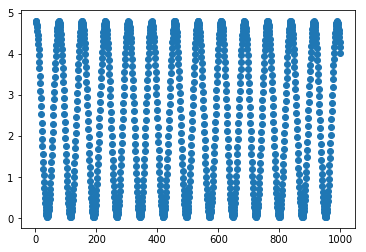

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_run = pd.read_csv("run_gla2_optimizeFirst.csv", sep=',', header=0)
run=np.asarray(df_run.loc[:,['step','loss','kinetic_energy', 'total_energy']])
plt.scatter(run[:,0], run[:,1])
#plt.savefig('loss-step.png', bbox_inches='tight')
plt.show()



# Averages

Trajectory has shape (1000, 3)


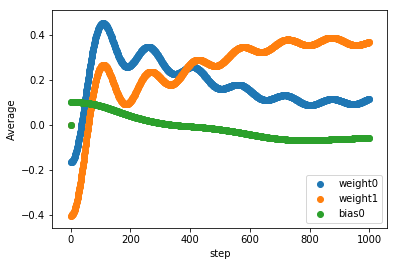

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from DataDrivenSampler.models.model import model

FLAGS = model.setup_parameters(
            trajectory_file="run_gla2_optimizeFirst.csv"
)
df_trajectory = pd.read_csv(FLAGS.trajectory_file, sep=',',header=0)
# check in which columns the weights are stores
#display(df_trajectory)
# save weigths only
traj=np.asarray(df_trajectory.values[:,3:])
print('Trajectory has shape '+repr(traj.shape))
conv=np.zeros(traj.shape)

# then we plot the running averages of the parameters
# inside weights
for i in range(1,traj.shape[0]):
    for d in range(traj.shape[1]):
        conv[i,d]=np.mean(traj[:i,d])
[plt.scatter(range(len(traj)), conv[:,i]) for i in range(traj.shape[1])]
plt.xlabel('step')
plt.ylabel('Average')

plt.legend(df_trajectory.axes[1][-3:])
#plt.savefig('step-parameters.png', bbox_inches='tight')
plt.show()




